# make dataset

In [11]:
import os
import numpy as np
from shutil import copy
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
import torch
import time
import torch.nn as nn
import torchvision.models as models
import time
import shutil

### construct the dataloader of fruit dataset


In [3]:
class LabImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img_original = self.transform(img)
            img_original = np.asarray(img_original)
#             img_original = img_original.transpose((2,1,0))
            
            img_lab = rgb2lab(img_original)
#             img_lab = (img_lab + 128) / 255
            img_ab = img_lab[:,:,1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2,0,1))).float()
        
            img_gray = img_lab[:,:,0]
            img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
            
        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return img_gray, img_ab

In [8]:
# training data
root_train = 'data/art_images/musemart/training_set/iconography'
root_test = 'data/art_images/musemart/validation_set/iconography'
train_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = LabImageFolder(root_train, train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)
# test data
test_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
test_imagefolder = LabImageFolder(root_test, test_transforms)
test_loader = torch.utils.data.DataLoader(test_imagefolder, batch_size=64, shuffle=True)

In [9]:
print(train_imagefolder.__len__())
print(test_imagefolder.__len__())

674
75


### construct model

In [12]:
class ColorizationNet(nn.Module):
    def __init__(self, input_size=128):
        super(ColorizationNet, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 128
        # ResNet
        resnet = models.resnet18(num_classes=10)
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])
        
        # upsampling
        self.upsample = nn.Sequential(     
        nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.Softmax(dim=1),
        nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
        nn.Upsample(scale_factor=2)
        )
        
    def forward(self, input):
        # Pass input through ResNet-gray to extract features
        input = (input-50)/100
        midlevel_features = self.midlevel_resnet(input)

        # Upsample to get colors
        output = self.upsample(midlevel_features)
        return output * 110

In [13]:
model = ColorizationNet()
model

ColorizationNet(
  (midlevel_resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

### some utils for pre/post processing

In [22]:
def load_img(img_path):
    img = np.asarray(Image.open(img_path))
    return img

def resize_img(img, HW=(256,256), resample=3):
    return np.asarray(Image.fromarray(img).resize(HW, resample=resample))

def preprocess_img(img_rgb_orig, HW=(256,256), resample=3):
    # return the original and resized L figure (lighting)
    img_rgb_rs = resize_img(img_rgb_orig, HW=HW, resample=resample)
    img_lab_orig = rgb2lab(img_rgb_orig)
    img_lab_rs = rgb2lab(img_rgb_rs)
    img_l_orig = img_lab_orig[:,:,0]
    img_l_rs = img_lab_rs[:,:,0]
    
    tensor_orig_l = torch.Tensor(img_l_orig)[None,None,:,:]
    tensor_rs_l = torch.Tensor(img_l_rs)[None,None,:,:]
    return tensor_orig_l, tensor_rs_l

def postprocess_img(tensor_orig_l, out_ab, mode='bilinear'):
    shape_orig = tensor_orig_l.shape[2:]
    shape_out = out_ab.shape[2:]
    if (shape_orig[0]!=shape_out[0] or shape_orig[1]!=shape_out[1]):
        out_ab_orig = torch.nn.functional.interpolate(out_ab, size=shape_orig, mode='bilinear')
    else:
        out_ab_orig = out_ab
    
    out_lab_orig = torch.cat((tensor_orig_l, out_ab_orig), dim=1)
    return lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))

def compare(model, path, HW=(256,256), use_gpu=False):
    img= load_img(path)
    tensor_orig_l, tensor_rs_l = preprocess_img(img, HW=HW)
    if use_gpu:
        tensor_orig_l, tensor_rs_l = tensor_orig_l.cuda(), tensor_rs_l.cuda()
    out_ab = model(tensor_rs_l)
    img_rec = postprocess_img(tensor_orig_l, out_ab)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('true')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img_rec)
    plt.title('colorized')
    plt.axis('off')
    plt.show()

In [23]:
class AverageMeter(object):
    '''A handy class from the PyTorch ImageNet tutorial''' 
    def __init__(self):
        self.reset()
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
    '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
    plt.clf() # clear matplotlib 
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
#     color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
#     color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    if save_path is not None and save_name is not None: 
#         plt.imshow(color_image)
        plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
        plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

### test

In [28]:
def validate(val_loader, model, criterion, save_images, epoch, use_gpu, test_loss):
    model.eval()

    # Prepare value counters and timers
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()
    already_saved_images = False
    for i, (input_gray, input_ab) in enumerate(val_loader):
        data_time.update(time.time() - end)

        # Use GPU
        if use_gpu: input_gray, input_ab = input_gray.cuda(), input_ab.cuda()

        # Run model and record loss
        output_ab = model(input_gray) # throw away class predictions
        loss = criterion(output_ab, input_ab)
        losses.update(loss.item(), input_gray.size(0))
        test_loss.append(loss.item())
        # Record time to do forward passes and save images
        batch_time.update(time.time() - end)
        end = time.time()

        # Print model accuracy -- in the code below, val refers to both value and validation
        if i % 25 == 0:
            print('Validate: [{0}/{1}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                 i, len(val_loader), batch_time=batch_time, loss=losses))

    # Save images to file
    if save_images and not already_saved_images:
        already_saved_images = True
        for j in range(4): # save at most 5 images
            input_gray = test_imagefolder[j][0][None,...]
            if use_gpu: input_gray = input_gray.cuda()
            output_ab = model(input_gray)
            save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
            save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
            to_rgb(input_gray[0].cpu(), ab_input=output_ab[0].detach().cpu(), save_path=save_path, save_name=save_name)
    print('Finished validation.')
    return losses.avg

In [27]:
def train(train_loader, model, criterion, optimizer, epoch, use_gpu, train_loss):
    print('Starting training epoch {}'.format(epoch))
    model.train()
    # Prepare value counters and timers
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()
    for i, (input_gray, input_ab) in enumerate(train_loader):

        # Use GPU if available
        if use_gpu: input_gray, input_ab = input_gray.cuda(), input_ab.cuda()

        # Record time to load data (above)
        data_time.update(time.time() - end)

        # Run forward pass
        output_ab = model(input_gray) 
        loss = criterion(output_ab, input_ab) 
        losses.update(loss.item(), input_gray.size(0))

        # Compute gradient and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        # Record time to do forward and backward passes
        batch_time.update(time.time() - end)
        end = time.time()

        # Print model accuracy -- in the code below, val refers to value, not validation
        if i % 25 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                  epoch, i, len(train_loader), batch_time=batch_time,
                 data_time=data_time, loss=losses)) 

    print('Finished training epoch {}'.format(epoch))

## train the model

In [82]:
model = ColorizationNet().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
use_gpu = torch.cuda.is_available()
if use_gpu: 
    criterion = criterion.cuda()
    model = model.cuda()
# if os.path.exists("outputs/color/"):
#     shutil.rmtree('outputs/gray/')    
# os.makedirs('outputs/color', exist_ok=True)
# os.makedirs('outputs/gray', exist_ok=True)
# os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 250
epochs = 50

In [13]:
total_params = sum(p.numel() for p in model.parameters())
print("total number of parameters: {}".format(total_params))

total number of parameters: 954722


In [83]:
# Train model
train_loss = []
test_loss = []
for epoch in range(epochs):
    # Train for one epoch, then validate
    train(train_loader, model, criterion, optimizer, epoch, use_gpu, train_loss)
    with torch.no_grad():
        losses = validate(test_loader, model, criterion, save_images, epoch, use_gpu, test_loss)
        # Save checkpoint and replace old best model if current model is better
    if losses < best_losses:
        best_losses = losses
        torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

Starting training epoch 0
Epoch: [0][0/15]	Time 2.082 (2.082)	Data 1.892 (1.892)	Loss 195.9002 (195.9002)	
Finished training epoch 0
Validate: [0/4]	Time 1.714 (1.714)	Loss 226.8074 (226.8074)	
Finished validation.
Starting training epoch 1
Epoch: [1][0/15]	Time 1.342 (1.342)	Data 1.152 (1.152)	Loss 172.7347 (172.7347)	
Finished training epoch 1
Validate: [0/4]	Time 1.144 (1.144)	Loss 165.8131 (165.8131)	
Finished validation.
Starting training epoch 2
Epoch: [2][0/15]	Time 1.355 (1.355)	Data 1.166 (1.166)	Loss 175.8324 (175.8324)	
Finished training epoch 2
Validate: [0/4]	Time 1.173 (1.173)	Loss 156.4415 (156.4415)	
Finished validation.
Starting training epoch 3
Epoch: [3][0/15]	Time 1.328 (1.328)	Data 1.147 (1.147)	Loss 197.0889 (197.0889)	
Finished training epoch 3
Validate: [0/4]	Time 1.175 (1.175)	Loss 161.5635 (161.5635)	
Finished validation.
Starting training epoch 4
Epoch: [4][0/15]	Time 1.305 (1.305)	Data 1.115 (1.115)	Loss 160.3531 (160.3531)	
Finished training epoch 4
Validat

Finished validation.
Starting training epoch 38
Epoch: [38][0/15]	Time 1.333 (1.333)	Data 1.144 (1.144)	Loss 160.6044 (160.6044)	
Finished training epoch 38
Validate: [0/4]	Time 1.158 (1.158)	Loss 190.2563 (190.2563)	
Finished validation.
Starting training epoch 39
Epoch: [39][0/15]	Time 1.309 (1.309)	Data 1.120 (1.120)	Loss 158.5240 (158.5240)	
Finished training epoch 39
Validate: [0/4]	Time 1.168 (1.168)	Loss 170.5246 (170.5246)	
Finished validation.
Starting training epoch 40
Epoch: [40][0/15]	Time 1.313 (1.313)	Data 1.123 (1.123)	Loss 158.7183 (158.7183)	
Finished training epoch 40
Validate: [0/4]	Time 1.180 (1.180)	Loss 164.1129 (164.1129)	
Finished validation.
Starting training epoch 41
Epoch: [41][0/15]	Time 1.323 (1.323)	Data 1.135 (1.135)	Loss 155.5021 (155.5021)	
Finished training epoch 41
Validate: [0/4]	Time 1.167 (1.167)	Loss 182.7182 (182.7182)	
Finished validation.
Starting training epoch 42
Epoch: [42][0/15]	Time 1.344 (1.344)	Data 1.155 (1.155)	Loss 162.3975 (162.3975)

<Figure size 432x288 with 0 Axes>

## compare fruit 

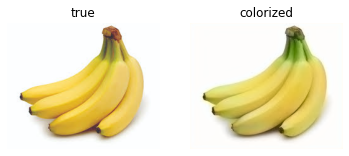

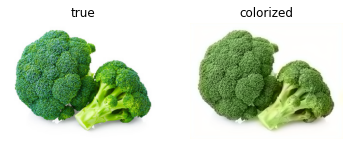

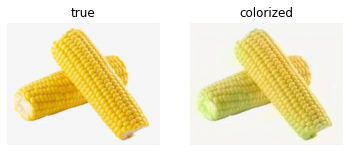

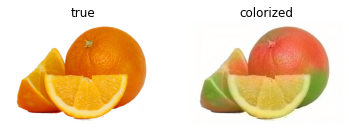

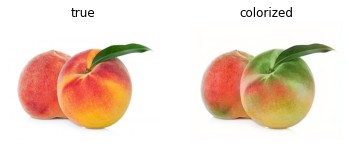

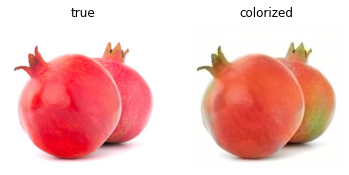

In [50]:
compare(model, 'data/test/Banana/Banana6.jpg', HW=(224,224), use_gpu=True)
compare(model, 'data/test/Broccoli/Broccoli6.jpg', HW=(224,224), use_gpu=True)
compare(model, 'data/test/Corn/Corn9.jpg', HW=(224,224), use_gpu=True)
compare(model, 'data/test/Orange/Orange7.jpg', HW=(224,224), use_gpu=True)
compare(model, 'data/test/Peach/Peach7.jpg', HW=(224,224), use_gpu=True)
compare(model, 'data/test/Pomegranate/PG48.jpg', HW=(224,224), use_gpu=True)


## compare iconography

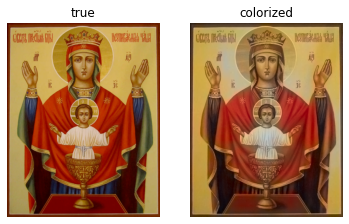

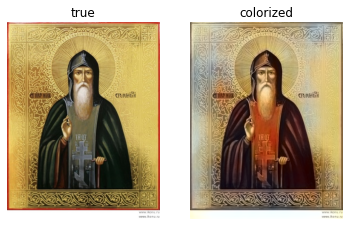

C:\Users\Hao\anaconda3\envs\torchgpu\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 21 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


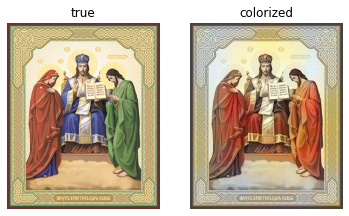

C:\Users\Hao\anaconda3\envs\torchgpu\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 700 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


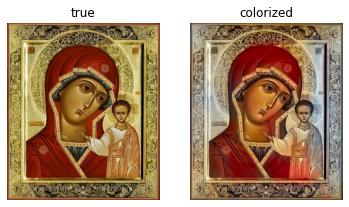

C:\Users\Hao\anaconda3\envs\torchgpu\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 361 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


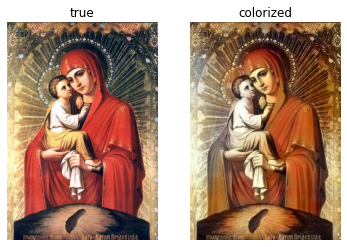

C:\Users\Hao\anaconda3\envs\torchgpu\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


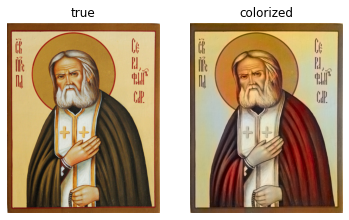

In [74]:
compare(model,'data/art_images/musemart/validation_set/iconography/total/1.jpg', HW=(224,224), use_gpu=True)
compare(model,'data/art_images/musemart/validation_set/iconography/total/3.jpg', HW=(224,224), use_gpu=True)
compare(model,'data/art_images/musemart/validation_set/iconography/total/45.jpg', HW=(224,224), use_gpu=True)
compare(model,'data/art_images/musemart/validation_set/iconography/total/152.jpg', HW=(224,224), use_gpu=True)
compare(model,'data/art_images/musemart/validation_set/iconography/total/224.jpg', HW=(224,224), use_gpu=True)
compare(model,'data/art_images/musemart/validation_set/iconography/total/345.jpg', HW=(224,224), use_gpu=True)


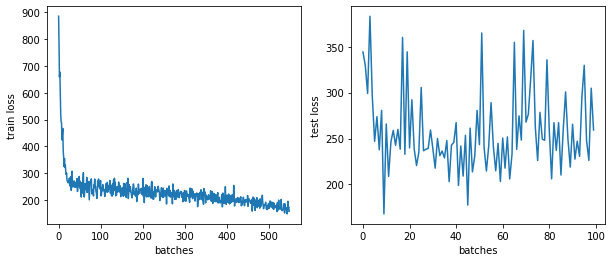

In [78]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(train_loss)
plt.xlabel('batches')
plt.ylabel('train loss')
plt.subplot(122)
plt.plot(test_loss)
plt.xlabel('batches')
plt.ylabel('test loss')
plt.show()

## compare PASCA dataset

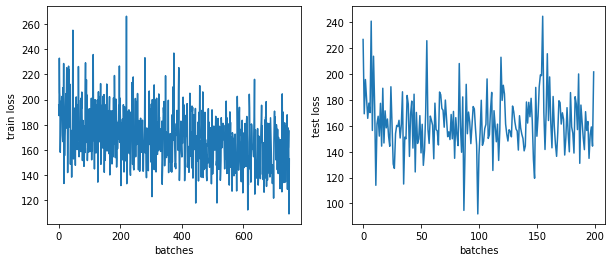

In [84]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(train_loss)
plt.xlabel('batches')
plt.ylabel('train loss')
plt.subplot(122)
plt.plot(test_loss)
plt.xlabel('batches')
plt.ylabel('test loss')
plt.show()

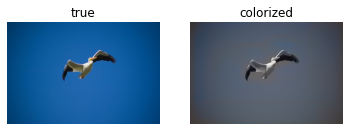

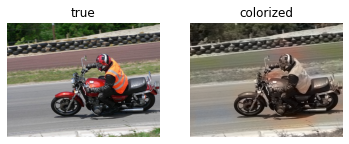

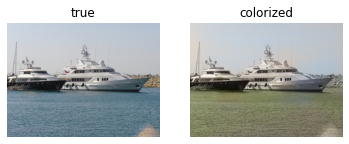

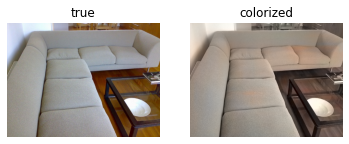

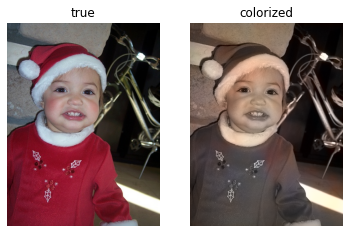

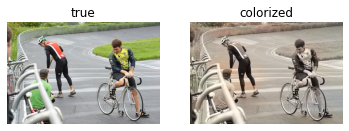

In [85]:
compare(model,'data/VOCdataset/test/total/008589.jpg', HW=(224,224), use_gpu=True)
compare(model,'data/VOCdataset/test/total/008597.jpg', HW=(224,224), use_gpu=True)
compare(model,'data/VOCdataset/test/total/008643.jpg', HW=(224,224), use_gpu=True)
compare(model,'data/VOCdataset/test/total/008650.jpg', HW=(224,224), use_gpu=True)
compare(model,'data/VOCdataset/test/total/008666.jpg', HW=(224,224), use_gpu=True)
compare(model,'data/VOCdataset/test/total/008839.jpg', HW=(224,224), use_gpu=True)

# hyperparameter tunning

In [34]:
def hyper_tunning(lr, epochs=20):
    model = ColorizationNet()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    use_gpu = torch.cuda.is_available()
    if use_gpu: 
        criterion = criterion.cuda()
        model = model.cuda()
    save_images = False
    train_loss = []
    test_loss = []
    # Train model
    for epoch in range(epochs):
        # Train for one epoch, then validate
        train(train_loader, model, criterion, optimizer, epoch, use_gpu, train_loss)
        with torch.no_grad():
            losses = validate(test_loader, model, criterion, save_images, epoch, use_gpu, test_loss)
    np.save('data/train_loss_fruit_lr_'+str(lr)+'.npy', np.asarray(train_loss))
    np.save('data/test_loss_fruit_lr_'+str(lr)+'.npy', np.asarray(test_loss))


In [39]:
hyper_tunning(0.0001, epochs=35)

Starting training epoch 0
Epoch: [0][0/9]	Time 1.343 (1.343)	Data 1.153 (1.153)	Loss 795.2208 (795.2208)	
Finished training epoch 0
Validate: [0/3]	Time 1.254 (1.254)	Loss 912.5780 (912.5780)	
Finished validation.
Starting training epoch 1
Epoch: [1][0/9]	Time 1.521 (1.521)	Data 1.318 (1.318)	Loss 815.8599 (815.8599)	
Finished training epoch 1
Validate: [0/3]	Time 1.260 (1.260)	Loss 833.7401 (833.7401)	
Finished validation.
Starting training epoch 2
Epoch: [2][0/9]	Time 1.466 (1.466)	Data 1.271 (1.271)	Loss 689.7466 (689.7466)	
Finished training epoch 2
Validate: [0/3]	Time 1.291 (1.291)	Loss 632.2255 (632.2255)	
Finished validation.
Starting training epoch 3
Epoch: [3][0/9]	Time 1.561 (1.561)	Data 1.364 (1.364)	Loss 641.3323 (641.3323)	
Finished training epoch 3
Validate: [0/3]	Time 1.211 (1.211)	Loss 631.8110 (631.8110)	
Finished validation.
Starting training epoch 4
Epoch: [4][0/9]	Time 1.530 (1.530)	Data 1.329 (1.329)	Loss 618.1720 (618.1720)	
Finished training epoch 4
Validate: [0

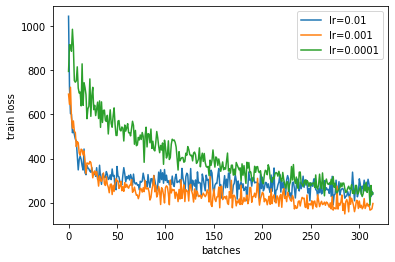

In [42]:
trainloss_1 = np.load('data/train_loss_fruit_lr_0.01.npy')
trainloss_2 = np.load('data/train_loss_fruit_lr_0.001.npy')
trainloss_3 = np.load('data/train_loss_fruit_lr_0.0001.npy')
plt.plot(trainloss_1)
plt.plot(trainloss_2)
plt.plot(trainloss_3)
plt.xlabel('batches')
plt.ylabel('train loss')
plt.legend(['lr=0.01', 'lr=0.001', 'lr=0.0001'])
plt.show()